In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from keras.models import model_from_json, load_model
import glob
from skimage.io import imread, imshow, imsave
from skimage.transform import resize, rotate
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.preprocessing import image

Using TensorFlow backend.


In [3]:
from keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.models import Model

from keras import backend as K
import tensorflow as tf
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    trs = np.linspace(0,0.5)
    recallm =  K.cast(1000.0, y_pred.dtype)
    for threshold in trs:
        #P(falsealarm) + 19⋅P(miss), что равно FP/(FP+TN) + 19⋅FN/(FN+TP).
        threshold = K.cast(threshold, y_pred.dtype)
        y_pred_t = K.cast(y_pred > threshold, y_pred.dtype)
        true_positives = K.sum(K.round(K.clip(y_true * y_pred_t, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recallm = K.minimum(recall, recallm)
    return recallm

def minC(y_true, y_pred):
    trs = np.linspace(0,0.5)
    minCm =  K.cast(1000.0, y_pred.dtype)
    for threshold in trs:
        #P(falsealarm) + 19⋅P(miss), что равно FP/(FP+TN) + 19⋅FN/(FN+TP).
        threshold = K.cast(threshold, y_pred.dtype)
        y_pred_t = K.cast(y_pred > threshold, y_pred.dtype)
        FP = K.sum(K.round(K.clip((1-y_true) * y_pred_t, 0, 1)))
        TP = K.sum(K.round(K.clip(y_true * y_pred_t, 0, 1)))
        FN = K.sum(K.round(K.clip(y_true * (1-y_pred_t), 0, 1)))
        TN = K.sum(K.round(K.clip((1-y_true) * (1-y_pred_t), 0, 1)))
        minC = FP/(FP+TN+ K.epsilon()) + 19*FN/(FN+TP+ K.epsilon())
        minCm = K.minimum(minC, minCm)
            
    return minCm

  
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [4]:
from keras.applications import DenseNet121
model = DenseNet121(weights = "imagenet", include_top=False, input_shape = (800, 800, 3))

from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2

x = model.output
x = Flatten()(x)

#x = Dense(2048, activation="elu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
#x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
#x = Dense(1024, activation="elu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
#x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)

from keras.models import Model
# creating the final model 
model_final = Model(input = model.input, output = predictions)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [5]:
model = load_model('./DensNet121_v1+v2_0.3test_1e-7lr.h5', compile=False)

In [5]:
model_final.load_weights('./DensNet121_test.h5')

In [6]:
model.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.00001, decay=0.0001), metrics=['accuracy',auc,f1, recall])

In [ ]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model.h5")


# evaluate loaded model on test data
loaded_model.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.0001, decay=0.0001), metrics=['accuracy',auc,f1, recall])

In [21]:
import cv2
import numpy as np
import os
import dlib

from sklearn.utils import shuffle
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose, JpegCompression
)


detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/home/neuralbee/Downloads/shape_predictor_68_face_landmarks.dat")
face_detector = dlib.get_frontal_face_detector()

def rect_to_tuple(rect):
    left = rect.left()
    right = rect.right()
    top = rect.top()
    bottom = rect.bottom()
    return left, top, right, bottom


def crop_image(image, det):
    left, top, right, bottom = rect_to_tuple(det)
    return image[top:bottom, left:right]

def get_head(img):
    
    img = img.astype(np.uint8)
    #print(np.max(img))
    #print(img.shape)
    det = detector(img, 1)[0]
    height, width = img.shape[:2]

    lr = det.right() - det.left()
    tb = det.bottom() - det.top()
    det = dlib.rectangle(left=max(0, det.left() - int(0.45 * lr)),
                         top=max(0, det.top() - int(0.9 * tb)),
                         right=min(width, det.right() + int(0.45 * lr)),
                         bottom=min(height, det.bottom() + int(0.55 * tb)))
    cropped = crop_image(img, det)
    return cropped

def rotateImage(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

In [10]:
for img_path in glob.glob('/home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/spoof1/*.jpg'):
    image = cv2.imread(img_path)
    image = rotateImage(image, 270)
    cv2.imwrite('/home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/spoof/'+ img_path.split('/')[-1], image)

In [11]:
ans = []
cnt = 0
for img_path in glob.glob('/home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/*.jpg'):
    
    try:
        img = image.load_img(img_path, target_size=(400, 400))
        #img = image.load_img(img_path)
        #img = cv2.resize(get_head(image.img_to_array(img)), (800, 800), cv2.INTER_NEAREST)/255.0
        img = image.img_to_array(img)/255.0
        #img = cv2.resize(get_head(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)), (800, 800), cv2.INTER_NEAREST)/255.0
        arr = np.array([img])
        res = model.predict(arr)
        print('###', img_path)
        print(res[0][0])
        
        ans.append(res[0][0])
    except Exception:
        print(img_path)

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/525_STS-482 Камера-видеоканал (17.jpg
0.252847
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/579_STS-482 Камера-видеоканал (14.jpg
0.0305183
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/477_STS-482 Камера-видеоканал (14.jpg
0.0450101
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/200_STS-482 Камера-видеоканал (14.jpg
0.0156661
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/179_STS-482 Камера-видеоканал (17.jpg
0.0292971
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/518_STS-482 Камера-видеоканал (17.jpg
0.0359326
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/247_STS-482 Камера-видеоканал (13.jpg
0.075252
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/14_STS-482 Камера-видеоканал (13.jpg
0.170745
### /home/ne

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/395_STS-482 Камера-видеоканал (14.jpg
0.0450913
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/213_STS-482 Камера-видеоканал (17.jpg
0.048056
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/331_STS-482 Камера-видеоканал (14.jpg
0.0404813
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/182_STS-482 Камера-видеоканал (17.jpg
0.0173256
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/722_STS-482 Камера-видеоканал (14.jpg
0.119481
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/371_STS-482 Камера-видеоканал (14.jpg
0.0118775
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/126_STS-482 Камера-видеоканал (13.jpg
0.130859
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/463_STS-482 Камера-видеоканал (14.jpg
0.0273937
### /home/n

### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/57_STS-482 Камера-видеоканал (13.jpg
0.218224
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/758_STS-482 Камера-видеоканал (14.jpg
0.0380376
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/379_STS-482 Камера-видеоканал (17.jpg
0.0882426
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/577_STS-482 Камера-видеоканал (14.jpg
0.0349128
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/4_STS-482 Камера-видеоканал (17.jpg
0.0152486
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/78_STS-482 Камера-видеоканал (13.jpg
0.0887043
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/521_STS-482 Камера-видеоканал (17.jpg
0.0731634
### /home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/149_STS-482 Камера-видеоканал (17.jpg
0.00820687
### /home/ne

KeyboardInterrupt: 

In [18]:
ans = np.array(ans)

In [19]:
ans.shape

(6577,)

In [22]:
len(ans[ans<1.0])

372

In [23]:
6200/6572

0.9433962264150944

In [19]:
get_head(cv2.cvtColor(cv2.imread('/home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/651_STS-482 Камера-видеоканал (14.jpg'), cv2.COLOR_BGR2RGB))

error: OpenCV(3.4.3) /io/opencv/modules/imgproc/src/color.cpp:181: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
/home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/579_STS-482 Камера-видеоканал (14.jpg

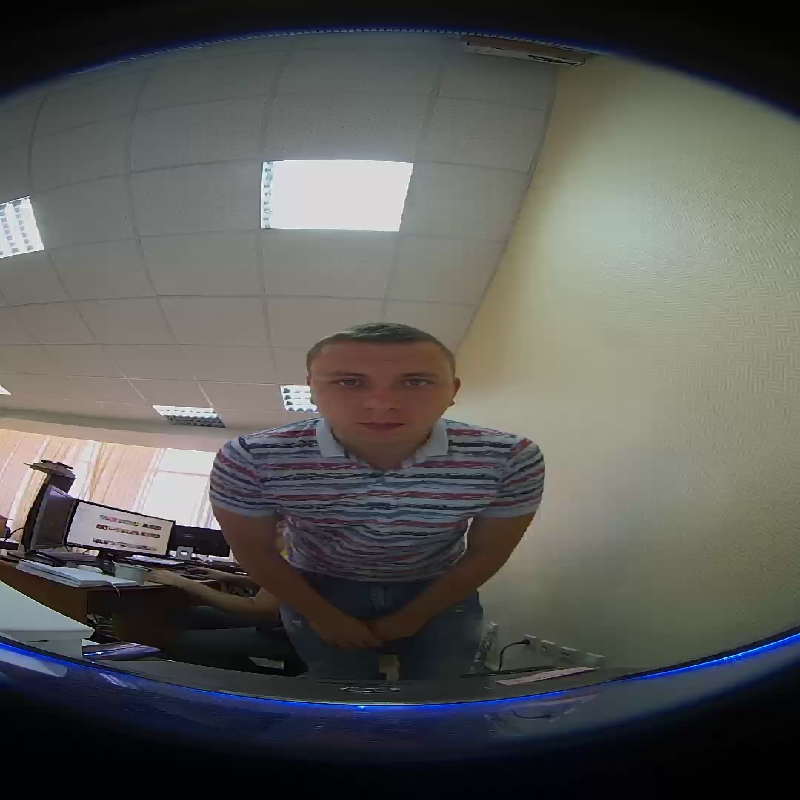

In [33]:
image.load_img("/home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/33_STS-482 Камера-видеоканал (17.jpg", target_size=(800, 800))

In [39]:
img_arr = image.img_to_array(image.load_img("/home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/33_STS-482 Камера-видеоканал (17.jpg", target_size=(800, 800)))

In [46]:
img1 = cv2.imread('/home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/33_STS-482 Камера-видеоканал (17.jpg')

255
(1920, 1080, 3)


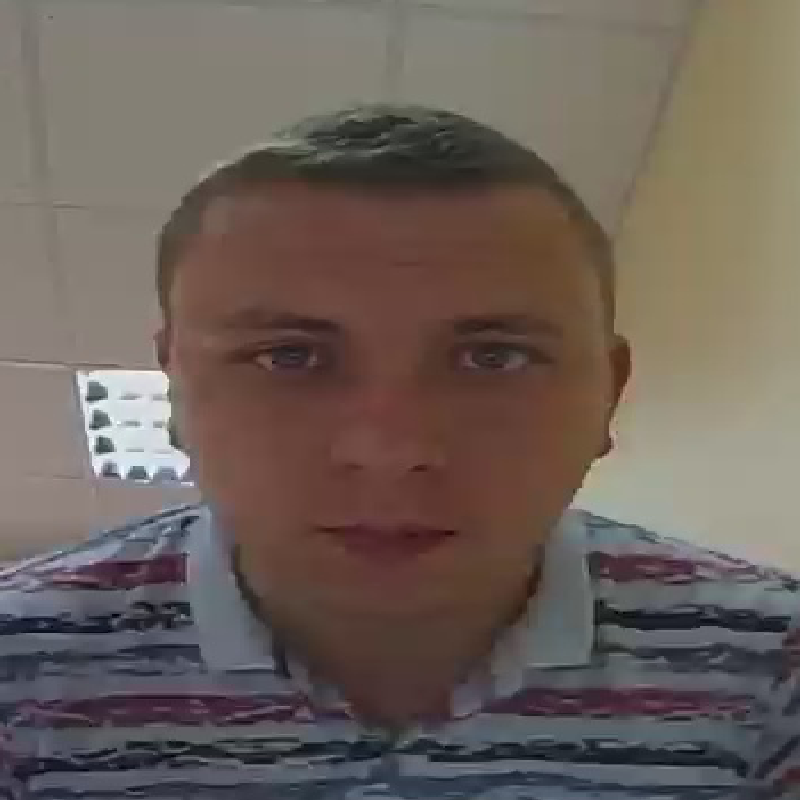

In [57]:
image.array_to_img(cv2.resize(get_head(image.img_to_array(image.load_img("/home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/real/33_STS-482 Камера-видеоканал (17.jpg"))), dsize=(800, 800), interpolation=cv2.INTER_NEAREST))

In [36]:
ans1 = []
cnt = 0
for img_path in glob.glob('/home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/spoof/*.jpg'):
    
    try:
        img = image.load_img(img_path, target_size=(800, 800))
        img = image.img_to_array(img)
        img *= 1./255
        arr = np.array([img])
        res = model_final.predict(arr)
        print(res[0][0])
        ans1.append(res[0][0])
    except Exception:
        print(img_path)

In [12]:
image_dir1 = '/home/neuralbee/workspace/anti_spoof_detection/our_data/images_dimon_collected/'
image_dir = '/home/neuralbee/workspace/anti_spoof_detection/our_data/images_val/'

In [13]:
train_real_filelist = glob.glob(os.path.join(image_dir, 'real/*.jpg'))
train_spoof_filelist = glob.glob(os.path.join(image_dir, 'spoof/*.jpg'))

In [14]:
train_filelist = train_real_filelist + train_spoof_filelist
train_labels = [0] * len(train_real_filelist) + [1] * len(train_spoof_filelist)

In [9]:
train_filelist = train_real_filelist #+ train_spoof_filelist
train_labels = [0] * len(train_real_filelist) #+ [1] * len(train_spoof_filelist)

In [16]:
import pandas as pd
test = pd.DataFrame()
test['path'] = train_filelist#[:100] + train_filelist[-100:-1]
test['label'] = train_labels#[:100] + train_labels[-100:-1]
test['label'] = test['label'].astype('str')

In [17]:
def my_gen(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except:
            pass

In [18]:
from keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)

In [26]:
test_generator = test_datagen.flow_from_dataframe(
        test, directory=None, x_col='path', 
        y_col='label', target_size=(400, 400),
        color_mode='rgb', 
        classes=None, 
        class_mode='binary',
        interpolation='nearest',
        batch_size=1,shuffle=False)

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = nb_samples)

Found 2882 images belonging to 2 classes.


In [27]:
predict

array([[ 0.25284886],
       [ 0.03051843],
       [ 0.04501034],
       ..., 
       [ 0.97143012],
       [ 0.90711874],
       [ 0.99834061]], dtype=float32)

In [25]:
recall(np.array(train_labels), predict)

AttributeError: 'numpy.dtype' object has no attribute 'base_dtype'

In [28]:
predict[-100:-1]

array([[ 0.97482741],
       [ 0.97864175],
       [ 0.98972613],
       [ 0.99338031],
       [ 0.96591794],
       [ 0.96064788],
       [ 0.98443097],
       [ 0.99748224],
       [ 0.98631847],
       [ 0.68265587],
       [ 0.99459559],
       [ 0.97296214],
       [ 0.98538095],
       [ 0.85947418],
       [ 0.99848348],
       [ 0.98364693],
       [ 0.99486649],
       [ 0.98077595],
       [ 0.9178291 ],
       [ 0.99391729],
       [ 0.90148073],
       [ 0.98072535],
       [ 0.98568404],
       [ 0.99052912],
       [ 0.98200548],
       [ 0.81871909],
       [ 0.98690403],
       [ 0.98951906],
       [ 0.98707747],
       [ 0.98163062],
       [ 0.97086126],
       [ 0.98347121],
       [ 0.95449227],
       [ 0.99143255],
       [ 0.99878222],
       [ 0.93542951],
       [ 0.98274082],
       [ 0.97552752],
       [ 0.95776886],
       [ 0.98759872],
       [ 0.97797924],
       [ 0.93302715],
       [ 0.92716646],
       [ 0.86886567],
       [ 0.9875049 ],
       [ 0

In [ ]:
reack